## Preprocessing
### Daten Laden

In [1]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
apartment_for_rent_classified = fetch_ucirepo(id=555) 
  
# data (as pandas dataframes) 
X = apartment_for_rent_classified.data.features 
y = apartment_for_rent_classified.data.targets 
print(y)

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\ucimlrepo\fetch.py:97: DtypeWarning: Columns (0,5,6,12,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


None


### Feature Comprehension
Wir schauen uns zunächst den Datensatz und die verschiedenen Features an
* category: housing/rent apartment the most data points
    * 64 data points belong to other categories like parking, gym, short term rent, ...
* title: the title the inserat is shown
* body: advertisment text
* amentities: gegebenheiten (Pool, alarm, gym, parking) -> hier müsste man preprocessen um austattungsfeatures zu bekommen, liegen als string vor
* bathrooms: muss auch preprocessed werden -> 7.5 alles als strings
* bedrooms: ""
* curency: except of 6 all USD
* fee: NO -> wir nehmen keine Miete
* pets_allowed: nicht informativ
* price: NaNs rauswerfen
* price_display: ich würde price nehmen
* price_type: Monthly nehmen







In [2]:
X.isna().sum()

category             0
title                0
body                 0
amenities        16077
bathrooms           66
bedrooms           127
currency             4
fee                  3
has_photo            3
pets_allowed     60634
price                5
price_display        6
price_type           3
square_feet          3
address          91880
cityname           305
state              305
latitude            29
longitude           31
source               6
time                 6
dtype: int64

In amnetities steht eine Liste als String von Ausstattungsmerkmalen. Aus der Liste werden keywords extrahiert:  
  
  ** ['pool', 'gym', 'parking', 'sauna', 'elevator', "clubhouse"]  **
  
Anschließend gibt es binäre Features zu jedem der Keyweords, ob das entsprechende Ausstattungsmerkmal in der Wohnung/Haus vorhanden ist

In [3]:
counts = X["amenities"].value_counts(dropna=False)

for value, count in counts.items():
    print(f"{value}: {count}")


nan: 16077
Parking: 6204
Parking,Storage: 2117
Gym,Pool: 1875
Pool: 1487
Gym,Parking,Pool: 1191
Parking,Pool: 889
Washer Dryer: 843
Patio/Deck: 776
Clubhouse,Gym,Pool: 768
Gym: 743
Parking,Patio/Deck,Storage: 667
Wood Floors: 627
Parking,Washer Dryer: 521
Gym,Patio/Deck,Pool: 519
Gym,Parking,Pool,Storage: 477
Clubhouse,Gym,Parking,Pool: 432
Parking,Patio/Deck: 427
Parking,Wood Floors: 424
Cable or Satellite,TV: 408
Storage: 399
Refrigerator: 399
Patio/Deck,Pool: 376
Clubhouse,Pool: 374
Gym,Parking: 339
Gym,Pool,Washer Dryer: 316
Gym,Parking,Pool,Washer Dryer: 313
Parking,Patio/Deck,Pool: 310
Dishwasher,Refrigerator: 303
Gym,Parking,Storage: 298
Gym,Pool,Storage: 298
Gym,Playground,Pool: 285
Fireplace: 282
Parking,Pool,Storage: 279
Parking,Storage,Washer Dryer: 271
AC: 265
Dishwasher: 217
Clubhouse,Gym: 215
Clubhouse,Parking,Pool: 210
Luxury: 206
Gym,Pool,Tennis: 203
Gated: 199
Playground,Pool: 190
AC,Parking: 183
Gym,Washer Dryer: 173
Fireplace,Gym,Pool: 168
Parking,Refrigerator: 166
C

In [4]:
keywords = ['pool', 'gym', 'parking', 'sauna', 'elevator', "clubhouse"]
# Für jedes Keyword eine neue 0/1-Spalte erzeugen
for kw in keywords:
    X[kw] = X['amenities'].str.contains(kw, case=False, na=False).astype(int)

Spalten die keinen Informationsgewinn bringen entfernen (pets, da zu viele None Einträge):  
- title
- body
- amenities (siehe oben --> bereits verarbeitet)
- pets_allowed
- address

In [5]:
columns_to_delete = ["title", "body", "amenities", "pets_allowed", "address", "price_display"]
X = X.drop(columns_to_delete, axis=1)
print(X.columns)

Index(['category', 'bathrooms', 'bedrooms', 'currency', 'fee', 'has_photo',
       'price', 'price_type', 'square_feet', 'cityname', 'state', 'latitude',
       'longitude', 'source', 'time', 'pool', 'gym', 'parking', 'sauna',
       'elevator', 'clubhouse'],
      dtype='object')


Für alle anderen Spalten entfernen jegliche Zeilen mit einem NaN Eintrag (ca. 500 Datenpunkte fallen raus)

In [6]:
cols_to_check = X.columns
print(X.shape)

# Lösche Zeilen, bei denen in einer der angegebenen Spalten None/NaN steht
X_clean = X.dropna(subset=cols_to_check)
print(X_clean.shape)

(99826, 21)
(99335, 21)


Als nächstes müssen wir die Daten in jedem Feature bereinigen
- nur Kategorie housing/rent/appartement betrachten
- Zeilen in numerische Werte umwandeln
- price_type = Monthly
- currency = USD
- fee = None
- One-Hot-Encoding für has_photo: 1, falls 'Yes' oder 'thumbnail' ;  0, sonst

In [7]:
import pandas as pd
import numpy as np

#Nur die Kategorie housing/rent/apartment soll untersucht werden, 80 datenpunkte fallen raus
X_clean = X_clean[X_clean["category"] == "housing/rent/apartment"]
X_clean = X_clean.drop("category", axis=1)

def keep_numeric_rows(df, columns):
    """
    Behalte nur die Zeilen, bei denen in den angegebenen Spalten 
    interpretierbare Zahlen stehen
    """
    df_clean = df.copy()
    for col in columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
        df_clean = df_clean[df_clean[col].notna()]
        print(f"{col}: {df_clean.shape[0]} Zeilen übrig")
    return df_clean

# Spalten, die geprüft werden sollen
cols_to_check = ["bathrooms", "bedrooms", "price", "square_feet", "longitude", "latitude"]
X_clean = keep_numeric_rows(X_clean, cols_to_check)


#price type monthly behalten
X_clean = X_clean[X_clean["price_type"] == "Monthly"]
X_clean = X_clean.drop("price_type", axis=1)
print(X_clean.shape)

#currency nur USD behalten
X_clean = X_clean[X_clean["currency"] == "USD"]
X_clean = X_clean.drop("currency", axis=1)
print(X_clean.shape)

#fee nur NO behalten
X_clean = X_clean[X_clean["fee"] == "No"]
X_clean = X_clean.drop("fee", axis=1)
print(X_clean.shape)

X_clean['has_photo'] = np.where(X_clean['has_photo'].isin(['Yes', 'thumbnail']), 1, 0)      
counts = X_clean["has_photo"].value_counts(dropna=False)

for value, count in counts.items():
    print(f"{value}: {count}")
    
#states removen, die nicht sinnvoll sind
state_to_remove = ['RentDigs.com', '1550831790']
X_clean = X_clean[~X_clean['state'].isin(state_to_remove)]
    


bathrooms: 99275 Zeilen übrig
bedrooms: 99275 Zeilen übrig
price: 99275 Zeilen übrig
square_feet: 99275 Zeilen übrig
longitude: 99275 Zeilen übrig
latitude: 99275 Zeilen übrig
(99272, 19)
(99272, 18)
(99075, 17)
1: 55903
0: 43172


Wir nehmen alle Sources mit auf, die mehr als 100 mal erscheinen

In [8]:

freq = X_clean['source'].value_counts()

threshold = 100

X_clean['source_mod'] = X_clean['source'].apply(lambda x: x if freq[x] > threshold else 'Andere source')

df_encoded = pd.get_dummies(X_clean['source_mod'], prefix='source').astype(int)

X_clean = X_clean.drop(columns=['source_mod'])

X_clean = pd.concat([X_clean, df_encoded], axis=1)
X_clean = X_clean.drop("source", axis=1)


States One-Hot-Encoden

In [9]:
states_one_hot = pd.get_dummies(X_clean["state"], prefix = "state").astype(int)
X_clean = pd.concat([X_clean, states_one_hot], axis=1)

In [10]:
print(X_clean.head())

   bathrooms  bedrooms  has_photo   price  square_feet       cityname state  \
0        1.0       1.0          0  2195.0        542.0  Redondo Beach    CA   
1        1.5       3.0          0  1250.0       1500.0   Newport News    VA   
2        2.0       3.0          0  1395.0       1650.0        Raleigh    NC   
3        1.0       2.0          0  1600.0        820.0      Vacaville    CA   
4        1.0       1.0          0   975.0        624.0    Albuquerque    NM   

   latitude  longitude          time  ...  state_SD  state_TN  state_TX  \
0   33.8520  -118.3759  1.577360e+09  ...         0         0         0   
1   37.0867   -76.4941  1.577360e+09  ...         0         0         0   
2   35.8230   -78.6438  1.577360e+09  ...         0         0         0   
3   38.3622  -121.9712  1.577360e+09  ...         0         0         0   
4   35.1038  -106.6110  1.577360e+09  ...         0         0         0   

   state_UT  state_VA  state_VT  state_WA  state_WI  state_WV  state_WY  


### Feature Engineering abgeschlossen

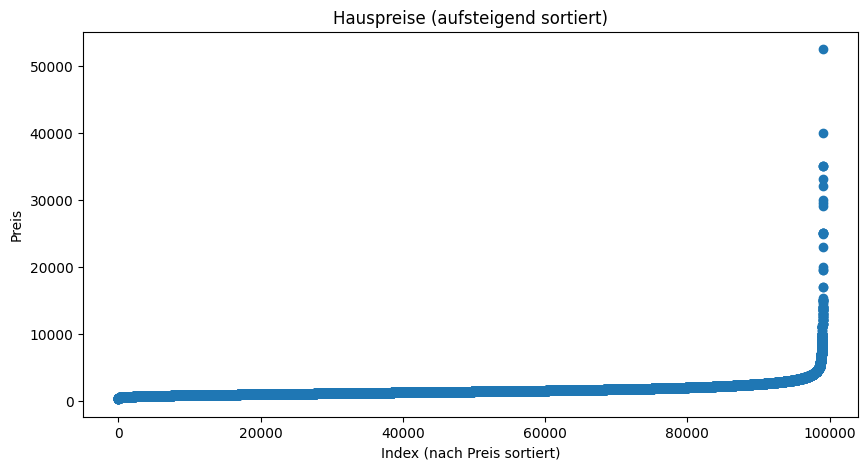

In [11]:
import matplotlib.pyplot as plt
# Preise sortieren
prices_sorted = X_clean["price"].sort_values().reset_index(drop=True)

# Plot

plt.figure(figsize=(10, 5))
plt.scatter(range(len(prices_sorted)), prices_sorted.values)
plt.xlabel("Index (nach Preis sortiert)")
plt.ylabel("Preis")
plt.title("Hauspreise (aufsteigend sortiert)")
plt.show()

# Outlier Detection in Target

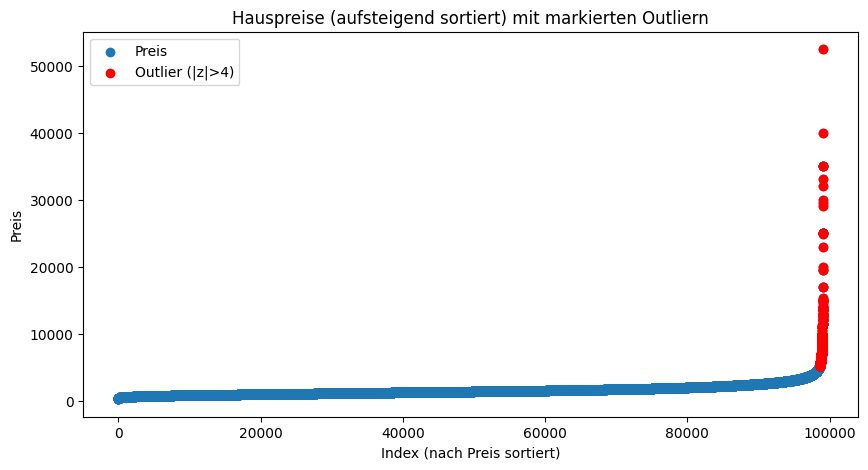

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore

# --- Outlier-Bestimmung ---
z = zscore(X_clean["price"])
is_outlier = np.abs(z) > 4

# Originalpreise + Outlier-Flag holen
prices = X_clean["price"]
outliers = prices[is_outlier]

# --- Für den Plot nach Preis sortieren ---
sorted_prices = prices.sort_values()
sorted_index = sorted_prices.index

# Auch Outlier entsprechend sortiert extrahieren
sorted_outliers = sorted_prices[sorted_prices.index.isin(outliers.index)]

# --- Plot ---
plt.figure(figsize=(10, 5))

# Alle Punkte
plt.scatter(range(len(sorted_prices)), sorted_prices.values, label="Preis", linewidth=1)

# Outlier rot markieren
plt.scatter(
    sorted_outliers.index.map(lambda i: sorted_index.get_loc(i)),  # Position im Sortierindex
    sorted_outliers.values,
    color="red",
    label="Outlier (|z|>4)",
    zorder=5
)

plt.xlabel("Index (nach Preis sortiert)")
plt.ylabel("Preis")
plt.title("Hauspreise (aufsteigend sortiert) mit markierten Outliern")
plt.legend()
plt.show()


In [13]:
# --- Outlier entfernen ---
z = zscore(X_clean["price"])
print(z.shape)
print(np.abs(z))

is_outlier = (np.abs(z) > 4)
print(is_outlier.astype(int).sum(), "viele Outlier")

X_clean_without_outliers = X_clean[~is_outlier]
print(X_clean.shape)


(99075,)
[0.74693392 0.30619328 0.14460233 ... 0.22261175 0.66169336 0.07828173]
453 viele Outlier
(99075, 73)


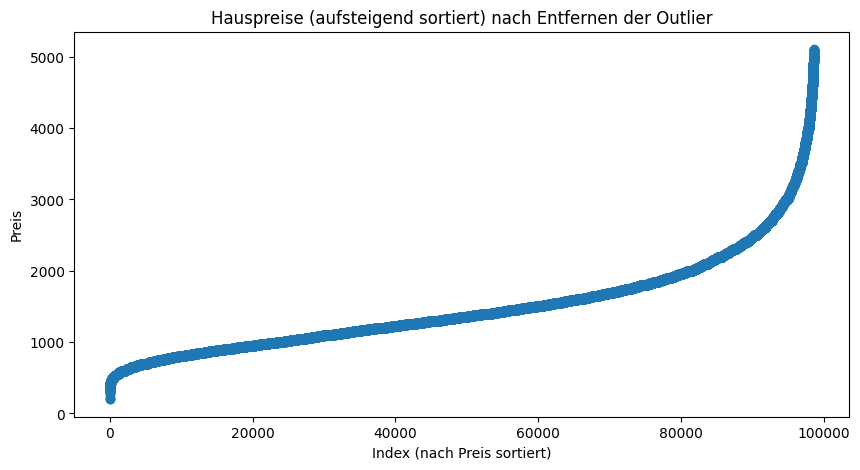

In [14]:

prices_sorted = X_clean_without_outliers["price"].sort_values().reset_index(drop=True)

# Plot

plt.figure(figsize=(10, 5))
plt.scatter(range(len(prices_sorted)), prices_sorted.values)
plt.xlabel("Index (nach Preis sortiert)")
plt.ylabel("Preis")
plt.title("Hauspreise (aufsteigend sortiert) nach Entfernen der Outlier")
plt.show()

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Calculate the frequency of each city name
city_counts = X_clean["cityname"].value_counts()

# 2. Print the top cities and their counts
print("\n--- City Name Counts ---")
print(city_counts)
# 2. Booleschen Index erstellen: Nur die Einträge auswählen, deren Anzahl (<10) ist
seltene_staedte_counts = city_counts[city_counts < 50]

# 3. Die Städtenamen (Index der Series) ausgeben
seltene_staedte_namen = seltene_staedte_counts.index.tolist()
X_clean_seltene_staedte = X_clean_without_outliers[X_clean_without_outliers["cityname"].isin(seltene_staedte_namen)]
print(len(X_clean_seltene_staedte), "Datenpunkte in seltenen Städten")

print("\n--- Städte, die weniger als 10 Mal vorkommen (Name und Anzahl) ---")
print(seltene_staedte_counts)

print("\n---Anzahl Städte mit weniger als 10 Mal vorkommen ---")
print(len(seltene_staedte_namen))



--- City Name Counts ---
cityname
Dallas            2858
Denver            2755
Los Angeles       2402
Las Vegas         1849
Arlington         1570
                  ... 
Felton               1
Suffern              1
Lovettsville         1
Welcome              1
Cape Canaveral       1
Name: count, Length: 2968, dtype: int64
20652 Datenpunkte in seltenen Städten

--- Städte, die weniger als 10 Mal vorkommen (Name und Anzahl) ---
cityname
Clementon         49
Riverdale         49
Milpitas          49
Fuquay Varina     49
Westborough       49
                  ..
Felton             1
Suffern            1
Lovettsville       1
Welcome            1
Cape Canaveral     1
Name: count, Length: 2580, dtype: int64

---Anzahl Städte mit weniger als 10 Mal vorkommen ---
2580


In [16]:
X_clean_without_outliers.columns

Index(['bathrooms', 'bedrooms', 'has_photo', 'price', 'square_feet',
       'cityname', 'state', 'latitude', 'longitude', 'time', 'pool', 'gym',
       'parking', 'sauna', 'elevator', 'clubhouse', 'source_Andere source',
       'source_GoSection8', 'source_ListedBuy', 'source_RealRentals',
       'source_RentDigs.com', 'source_RentLingo', 'state_AK', 'state_AL',
       'state_AR', 'state_AZ', 'state_CA', 'state_CO', 'state_CT', 'state_DC',
       'state_DE', 'state_FL', 'state_GA', 'state_HI', 'state_IA', 'state_ID',
       'state_IL', 'state_IN', 'state_KS', 'state_KY', 'state_LA', 'state_MA',
       'state_MD', 'state_ME', 'state_MI', 'state_MN', 'state_MO', 'state_MS',
       'state_MT', 'state_NC', 'state_ND', 'state_NE', 'state_NH', 'state_NJ',
       'state_NM', 'state_NV', 'state_NY', 'state_OH', 'state_OK', 'state_OR',
       'state_PA', 'state_RI', 'state_SC', 'state_SD', 'state_TN', 'state_TX',
       'state_UT', 'state_VA', 'state_VT', 'state_WA', 'state_WI', 'state_WV',
   

In [20]:
X_clean_without_outliers.drop(columns=['latitude', 'longitude', 'time'], inplace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_4366288\936418963.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_clean_without_outliers.drop(columns=['latitude', 'longitude', 'time'], inplace=True)


In [21]:
X_clean_without_outliers.to_csv("preprocessed_apartment_rentals_one_hot_encoded_states.csv", index=False)

In [ ]:
import pandas as pd

data = pd.read_csv("preprocessed_apartment_rentals_one_hot_encoded_states.csv")
print(data["state"])
# alle Spalten droppen, die mit 'state_' anfangen
cols_to_drop = [col for col in data.columns if col.startswith("state_")]
data = data.drop(columns=cols_to_drop)
data.to_csv("preprocessed_apartment_rentals_no_state_dummies_nocluster.csv", index=False)